<a href="https://colab.research.google.com/github/krbok/IITBHU/blob/main/Copy_of_Final_IIT_BHU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/dataset_1.csv'
df = pd.read_csv(file_path)

# Step 1: Fill missing dates using forward fill
df['Date'] = df['Date'].fillna(method='ffill')

# Step 2: Combine Date and Time (Local) into a datetime column
df['datetime'] = pd.to_datetime(df['Date'], format='%d-%b-%y') + pd.to_timedelta(df['Time (Local)'], unit='h')

# Step 3: Strip whitespace from column names
df.columns = df.columns.str.strip()

# Step 4: Sort the data by datetime
df = df.sort_values(by='datetime').reset_index(drop=True)

# Display the first few rows to confirm preprocessing
print(df.head())


        Date  Time (Local)  Eyeballs  Zeroes  Completed Trips  Requests  \
0  10-Sep-12             7         5       0                2         2   
1  10-Sep-12             8         6       0                2         2   
2  10-Sep-12             9         8       3                0         0   
3  10-Sep-12            10         9       2                0         1   
4  10-Sep-12            11        11       1                4         4   

   Unique Drivers            datetime  
0               9 2012-09-10 07:00:00  
1              14 2012-09-10 08:00:00  
2              14 2012-09-10 09:00:00  
3              14 2012-09-10 10:00:00  
4              11 2012-09-10 11:00:00  


<ipython-input-1-7d285fa553de>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Date'] = df['Date'].fillna(method='ffill')


In [ ]:
# Calculate rolling 24-hour sum of Completed Trips
df['rolling_24h_trips'] = df.apply(
    lambda row: df[(df['datetime'] >= row['datetime']) &
                   (df['datetime'] < row['datetime'] + pd.Timedelta(hours=24))]['Completed Trips'].sum(), axis=1
)

# Find the maximum rolling 24-hour trips and corresponding start time
max_trips_row = df.loc[df['rolling_24h_trips'].idxmax()]

# Display the result
print("Highest number of completed trips in a 24-hour period:")
print(f"Start Time: {max_trips_row['datetime']}")
print(f"Completed Trips: {max_trips_row['rolling_24h_trips']}")



Highest number of completed trips in a 24-hour period:
Start Time: 2012-09-21 17:00:00
Completed Trips: 278


In [ ]:
# Step 1: Define weekends (Friday 5 PM to Sunday 3 AM)
def is_weekend(date_time):
    day_of_week = date_time.weekday()  # Monday = 0, Sunday = 6
    hour = date_time.hour
    # Friday 5 PM (17) to Sunday 3 AM (hour < 3)
    return (day_of_week == 4 and hour >= 17) or (day_of_week == 5) or (day_of_week == 6 and hour < 3)

# Step 2: Create a weekend indicator column
df['is_weekend'] = df['datetime'].apply(is_weekend)

# Step 3: Calculate zeroes during weekends and total zeroes
total_zeroes = df['Zeroes'].sum()
weekend_zeroes = df[df['is_weekend']]['Zeroes'].sum()

# Step 4: Calculate the percentage
percentage_weekend_zeroes = (weekend_zeroes / total_zeroes) * 100

# Display the results
print("Percentage of zeroes occurring during weekends:")
print(f"{percentage_weekend_zeroes:.2f}%")


Percentage of zeroes occurring during weekends:
44.86%


In [ ]:
# Step 1: Calculate the ratio of Completed Trips to Unique Drivers
df['trips_per_driver_ratio'] = df['Completed Trips'] / df['Unique Drivers']

# Step 2: Calculate the weighted average ratio
total_drivers = df['Unique Drivers'].sum()
weighted_average_ratio = (df['trips_per_driver_ratio'] * df['Unique Drivers']).sum() / total_drivers

# Display the result
print("Weighted Average Ratio of Completed Trips per Driver:")
print(f"{weighted_average_ratio:.2f}")


Weighted Average Ratio of Completed Trips per Driver:
0.51


In [ ]:
# Step 1: Define a new column for shift groups (every 8 hours)
df['shift_start'] = df['datetime'].dt.floor('8H')  # Group datetime into 8-hour blocks

# Step 2: Calculate total Unique Requests for each shift
shift_requests = df.groupby('shift_start')['Requests'].sum().reset_index()

# Step 3: Identify the shift with the highest Unique Requests
max_shift = shift_requests.loc[shift_requests['Requests'].idxmax()]

# Display the result
print("Busiest 8-hour shift in terms of Unique Requests:")
print(f"Shift Start: {max_shift['shift_start']}")
print(f"Total Unique Requests: {max_shift['Requests']}")



Busiest 8-hour shift in terms of Unique Requests:
Shift Start: 2012-09-21 16:00:00
Total Unique Requests: 192


<ipython-input-5-45b9b2cd0af5>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['shift_start'] = df['datetime'].dt.floor('8H')  # Group datetime into 8-hour blocks


In [ ]:
df['Supply_Increases'] = df['Unique Drivers'].diff() > 0  # Use Unique Drivers
df['Demand_Increases'] = df['Requests'].diff() > 0
correlation_check = (df['Supply_Increases'] == df['Demand_Increases']).all()
print(f"Driver supply always increases with demand: {correlation_check}")


Driver supply always increases with demand: False


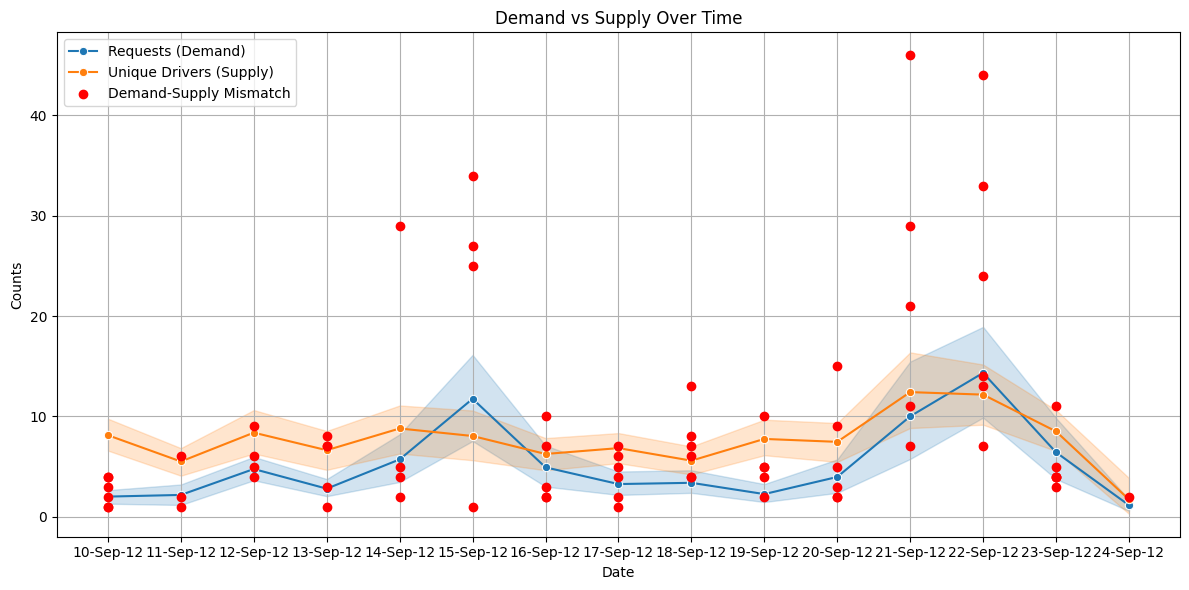

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate the difference for Requests and Unique Drivers
demand_supply_relationship = df[['Requests', 'Unique Drivers']].diff()

# Identify mismatched cases
mismatched_cases = df[(demand_supply_relationship['Requests'] > 0) &
                                    (demand_supply_relationship['Unique Drivers'] <= 0)]


# Plot the trends for Requests and Unique Drivers over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Requests', label='Requests (Demand)', marker='o')
sns.lineplot(data=df, x='Date', y='Unique Drivers', label='Unique Drivers (Supply)', marker='o')

# Highlight mismatched cases
if not mismatched_cases.empty:
    plt.scatter(
        mismatched_cases['Date'],
        mismatched_cases['Requests'],
        color='red',
        label='Demand-Supply Mismatch',
        zorder=5
    )

# Customize the plot
plt.title('Demand vs Supply Over Time')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Ensure datetime is the index
df = df.set_index('datetime')

# Question 6: 72-hour period with the highest Zeroes to Eyeballs ratio
df['72H_Zeroes'] = df['Zeroes'].rolling('72H').sum()  # Rolling sum of Zeroes over 72 hours
df['72H_Eyeballs'] = df['Eyeballs'].rolling('72H').sum()  # Rolling sum of Eyeballs over 72 hours
df['72H_Ratio'] = df['72H_Zeroes'] / df['72H_Eyeballs']  # Ratio of Zeroes to Eyeballs

# Find the starting datetime of the highest ratio
highest_ratio_period = df['72H_Ratio'].idxmax()
print(f"72-hour period with the highest Zeroes to Eyeballs ratio starts at: {highest_ratio_period}")



72-hour period with the highest Zeroes to Eyeballs ratio starts at: 2012-09-18 04:00:00


<ipython-input-9-552e4444a7dd>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['72H_Zeroes'] = df['Zeroes'].rolling('72H').sum()  # Rolling sum of Zeroes over 72 hours
<ipython-input-9-552e4444a7dd>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['72H_Eyeballs'] = df['Eyeballs'].rolling('72H').sum()  # Rolling sum of Eyeballs over 72 hours


In [ ]:
# Calculate unmet demand for each record
df['Unmet Demand'] = df['Requests'] - df['Unique Drivers']

# Group by hour to calculate total unmet demand for each hour
hourly_unmet_demand = df.groupby('Time (Local)')['Unmet Demand'].sum()

# Find the hour with the highest total unmet demand
optimal_hour = hourly_unmet_demand.idxmax()
highest_unmet_demand = hourly_unmet_demand.max()

# Display the results
print(f"The optimal hour to add 5 drivers is {optimal_hour}:00, which has a total unmet demand of {highest_unmet_demand} over the two-week period.")


The optimal hour to add 5 drivers is 23:00, which has a total unmet demand of 65 over the two-week period.


In [ ]:
# Group by hour to find the average number of Unique Requests
hourly_requests = df.groupby(df['datetime'].dt.hour)['Requests'].mean()
end_day_hour = hourly_requests.idxmin()  # Hour with the least activity
print(f"Optimal time for a true 'end day': {end_day_hour}:00")


Optimal time for a true 'end day': 4:00
